In [97]:
import numpy as np
import numpy.linalg as lg
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os
import math
from Matern import Matern

In [98]:
# test x
# baseline = np.load("../baseline_results.npy")
baseline = np.load("../filtered_baseline.npy")
print(baseline.shape)
baseline_x = baseline[:, 0]

coor_x = np.load("../coor_x.npy")


(398, 5)


In [99]:
data = np.load("21.npy")

indexes = np.int32(data[:, 0])
# y = np.mod(data[:, 5] - baseline_x[indexes] + 3*math.pi, 2*math.pi).reshape(-1, 1) - math.pi
y = (data[:, 1] - baseline_x[indexes]).reshape(-1, 1)
x = coor_x[indexes]

[6.40270213e-01 1.78855472e+01 9.80977303e-01 9.11610079e-01
 3.18674455e+02 3.80040699e-02]


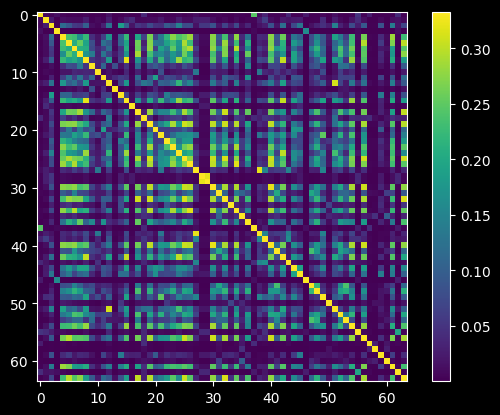

In [100]:
# initial guess

coef = lg.inv(x.T @ x) @ x.T @ y
prediction = x @ coef 

kernel = Matern(np.ones(5))

def negative_log_likelihood(params, data_x, diff_y):
    length_scale = params[:-1]
    noise_ratio = params[-1]

    cov = kernel(data_x, length_scale) + np.eye(64) * noise_ratio
    # result =  0.5 * diff_y.T @ lg.inv(cov) @ diff_y + 0.5 * np.log(lg.det(cov)+1e-10)
    result = 32*np.log(diff_y.T @ lg.inv(cov) @ diff_y)
    sign, log_det = lg.slogdet(cov)
    log_det = log_det if sign else -100
    result += 0.5*log_det
    # 0.5*np.log(lg.det(cov)) 

    return float(result)


diff_y = y - prediction
# diff_y = np.where(diff_y > 1, 1, diff_y)
# diff_y = np.where(diff_y < -1, -1, diff_y)

results = []
for initial_noise_ratio in (1, 0.5, 0.01):
    res = minimize(negative_log_likelihood, 
                np.array([1 for i in range(5)] + [initial_noise_ratio]), 
                args=(x, diff_y), 
                bounds=np.array([
                    [1e-5, 1e4],
                    [1e-5, 1e4], 
                    [1e-5, 1e4],
                    [1e-5, 1e4],
                    [1e-5, 1e4],
                    [1e-6, 1e6]]))
    results.append(res)

best_res = min(results, key=lambda x: x.fun)
print(best_res.x)
# print(res.fun)


length_scale = best_res.x[:5]
noise_ratio = best_res.x[-1]
cov = kernel(x, length_scale) + np.eye(64) * noise_ratio
prior_var =  diff_y.T @ lg.inv(cov) @ diff_y / 64
cov *= prior_var
plt.imshow(cov)
plt.colorbar()
plt.show()


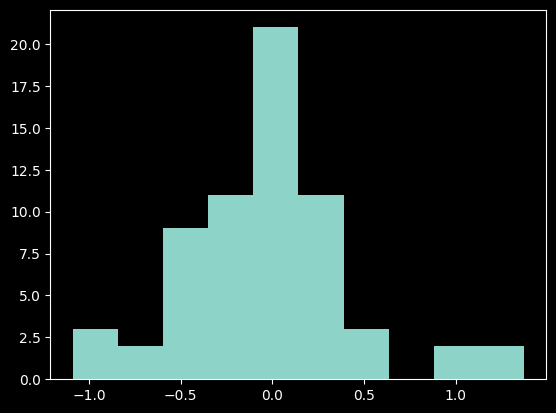

In [101]:
plt.hist(diff_y)
plt.show()

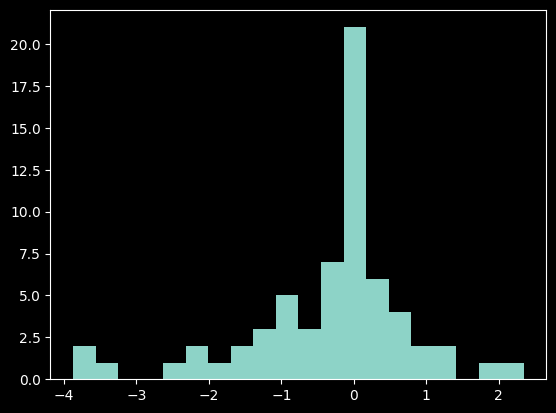

In [102]:
plt.hist(y, bins=20)
plt.show()

In [103]:
print(np.mean(diff_y**2), np.mean(y**2))

0.21588034018976546 1.4002078


In [104]:
# coef = lg.inv(x.T @ x) @ x.T @ y
# print(coef)

# loss = np.mean(np.square(x @ coef - y))
# print(loss)

# prior_loss = np.mean(np.square(y))
# print(prior_loss)